<center>
<img src="https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

<center>
Auteur: [Yury Kashnitskiy](https://yorko.github.io).  
Traduit et édité par [Serge Oreshkov](https://www.linkedin.com/in/sergeoreshkov/), [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/) et [Ousmane Cissé](https://www.linkedin.com/in/ousmane-ciss%C3%A9/).  
Ce matériel est soumis aux termes et conditions de la licence [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).  
L'utilisation gratuite est autorisée à des fins non commerciales.

# <center> Topic 8. Vowpal Wabbit: apprendre avec des gigaoctets de données
Cette semaine, nous aborderons deux raisons qui expliquent la vitesse d'entraînement exceptionnelle de Vowpal Wabbit, à savoir l'apprentissage en ligne et le hashing trick, tant en théorie qu'en pratique. Nous allons l'essayer avec des articles d'actualités, des critiques de films et des questions sur le StackOverflow.

# Plan de l'article
1. [Stochastic gradient descent and online learning](#1.-Stochastic-gradient-descent-and-online-learning)
    - 1.1. [SGD](#1.1.-Stochastic-gradient-descent)
    - 1.2. [Online approach to learning](#1.2.-Online-approach-to-learning)
2. [Categorical feature processing](#2.-Categorical-feature-processing)
    - 2.1. [Label Encoding](#2.1.-Label-Encoding)
    - 2.2. [One-Hot Encoding](#2.2.-One-Hot-Encoding)
    - 2.3. [Hashing trick](#2.3.-Hashing-trick)
3. [Vowpal Wabbit](#3.-Vowpal-Wabbit)
    - 3.1. [News. Binary classification](#3.1.-News.-Binary-classification)
    - 3.2. [News. Multiclass classification](#3.2.-News.-Multiclass-classification)
    - 3.3. [IMDB movie reviews](#3.3.-IMDB-movie-reviews)
    - 3.4. [Classifying gigabytes of StackOverflow questions](#3.4.-Classifying-gigabytes-of-StackOverflow-questions)
4. [Demo assignment](#4.-Demo-assignment)
5. [Useful resources](#5.-Useful-resources)

In [1]:
import os
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    log_loss,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm import tqdm_notebook

%matplotlib inline
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")

## 1. Descente de gradient stochastique et apprentissage en ligne
### 1.1. Descente de gradient stochastique

Bien que la descente de gradient soit l'une des premières choses apprises dans les cours d'apprentissage automatique et d'optimisation, c'est l'une de ses modifications, la descente de gradient stochastique (SGD), qui est difficile à surmonter.

Rappelons que l'idée de la descente en gradient est de minimiser certaines fonctions en faisant de petits pas dans le sens de la décroissance la plus rapide. Cette méthode a été nommée en raison du fait suivant du calcul: le vecteur $\nabla f = (\frac{\partial f}{\partial x_1}, \ldots \frac{\partial f}{\partial x_n})^\text{T}$ des dérivées partielles de la fonction $f(x) = f(x_1, \ldots x_n)$ pointe vers la direction de la croissance de la fonction la plus rapide. Cela signifie qu'en se déplaçant dans la direction opposée (antigradient), il est possible de diminuer la valeur de la fonction avec le taux le plus rapide.

<img src='https://habrastorage.org/files/4f2/75d/a46/4f275da467a44fc4a8d1a11007776ed2.jpg' width=50%>

Voici un snowboarder (moi) à Sheregesh, la station d'hiver la plus populaire de Russie. (Je le recommande vivement si vous aimez le ski ou le snowboard). En plus de faire la publicité des beaux paysages, cette image dépeint l'idée d'une descente en pente. Si vous voulez rouler le plus vite possible, vous devez choisir le chemin de descente le plus raide. Le calcul des antigradients peut être considéré comme une évaluation de la pente à divers endroits.

**Exemple**

Le problème de la régression par paires peut être résolu par la descente en pente. Prévoyons une variable à l'aide d'une autre : la taille avec le poids. Supposons que ces variables soient linéairement dépendantes. Nous utiliserons l'ensemble de données [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data).

In [3]:
PATH_TO_ALL_DATA = "../../data/"
data_demo = pd.read_csv(os.path.join(PATH_TO_ALL_DATA, "weights_heights.csv"))

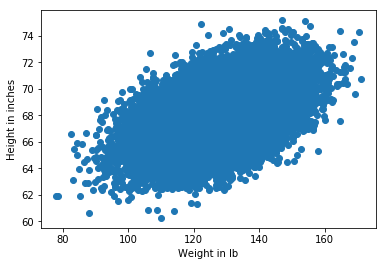

In [4]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Weight in lb")
plt.ylabel("Height in inches");

Nous avons un vecteur $x$ de dimension $\ell$ (poids de chaque personne, c'est-à-dire un échantillon d'entraînement) et $y$, un vecteur contenant la taille de chaque personne dans l'ensemble de données.

La tâche est la suivante: trouver les poids $w_0$ et $w_1$ de telle sorte que la prédiction de la hauteur comme $y_i = w_0 + w_1 x_i$ (où $y_i$ est la valeur de hauteur $i$-th, $x_i$ est la valeur de poids $i$-th) minimise l'erreur quadratique (ainsi que l'erreur quadratique moyenne car $\frac{1}{\ell}$ ne fait aucune différence):
$$SE(w_0, w_1) = \frac{1}{2}\sum_{i=1}^\ell(y_i - (w_0 + w_1x_{i}))^2 \rightarrow min_{w_0,w_1}$$

Nous utiliserons la descente de gradient, en utilisant les dérivées partielles de $SE(w_0, w_1)$ sur les poids $w_0$ et $w_1$.
Une procédure d'apprentissage itérative est alors définie par de simples formules de mise à jour (on modifie les poids du modèle par petits pas, proportionnels à une petite constante $\eta$, vers l'antigradient de la fonction $SE(w_0, w_1)$):

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} -\eta \frac{\partial SE}{\partial w_0} |_{t} \\  w_1^{(t+1)} = w_1^{(t)} -\eta \frac{\partial SE}{\partial w_1} |_{t} \end{array}$$

En calculant les dérivées partielles, nous obtenons ce qui suit:

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta \sum_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta \sum_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

Ce calcul fonctionne très bien tant que la quantité de données n'est pas importante (nous ne discuterons pas des problèmes avec les minima locaux, les points-selle, le choix du taux d'apprentissage, des moments et d'autres choses - ces sujets sont traités en détail dans [the Numeric Computation chapter in "Deep Learning"](http://www.deeplearningbook.org/contents/numerical.html)).
Il y a un problème avec la descente de gradient par lots - l'évaluation du gradient nécessite la somme d'un certain nombre de valeurs pour chaque objet de l'ensemble d'apprentissage. En d'autres termes, l'algorithme nécessite beaucoup d'itérations, et chaque itération recalcule les poids avec une formule qui contient une somme $\sum_{i=1}^\ell$ sur l'ensemble de l'entraînement. Que se passe-t-il lorsque nous avons des milliards d'échantillons d'entraînement?

<img src="https://habrastorage.org/webt/ow/ng/cs/owngcs-lzoguklv1pn9vz_r4ssm.jpeg" />

D'où la motivation pour une descente de gradient stochastique! Autrement dit, nous jetons le signe de sommation et mettons à jour les poids uniquement sur des échantillons d'entraînement uniques (ou un petit nombre d'entre eux). Dans notre cas, nous avons les éléments suivants:

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

Avec cette approche, rien ne garantit que nous irons dans la meilleure direction possible à chaque itération. Par conséquent, nous pouvons avoir besoin de beaucoup plus d'itérations, mais nous obtenons des mises à jour de poids beaucoup plus rapides.

Andrew Ng a fait une bonne illustration dans son [cours d'apprentissage automatique](https://www.coursera.org/learn/machine-learning). Jetons un coup d'oeil.

<img src='https://habrastorage.org/files/f8d/90c/f83/f8d90cf83b044255bb07df3373f25fc7.png'>

Ce sont les tracés de contour pour une fonction, et nous voulons trouver le minimum global de cette fonction. La courbe rouge montre les changements de poids (dans cette image, $\theta_0$ et $\theta_1$ correspondent à nos $w_0$ et $w_1$). Selon les propriétés d'un gradient, la direction du changement en chaque point est orthogonale aux courbes de niveau. Avec la descente de gradient stochastique, les poids changent de manière moins prévisible, et il peut même sembler que certaines étapes sont fausses en s'éloignant des minima; cependant, les deux procédures convergent vers la même solution.

### 1.2. Approche d'apprentissage en ligne
La descente de gradient stochastique nous donne des conseils pratiques pour la formation des classificateurs et des régresseurs avec de grandes quantités de données jusqu'à des centaines de Go (en fonction des ressources de calcul).

En considérant le cas de la régression par paires, nous pouvons stocker l'ensemble de données d'apprentissage $(X,y)$ dans le disque dur sans le charger dans la RAM (où il ne rentre tout simplement pas), lire les objets un par un et mettre à jour les poids de notre modèle:

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

Après avoir travaillé sur la totalité de l'ensemble de données d'entraînement, notre fonction de perte (par exemple, l'erreur quadratique de racine carrée dans la régression ou la perte logistique dans la classification) diminuera, mais il faut généralement des dizaines de passes sur l'ensemble d'entraînement pour rendre la perte suffisamment petite.

Cette approche de l'apprentissage s'appelle **apprentissage en ligne**, et ce nom est apparu avant même que les MOOC d'apprentissage automatique ne deviennent courants.

Nous n'avons pas discuté ici de nombreux détails sur SGD. Si vous voulez plonger dans la théorie, je vous recommande vivement ["Convex Optimization" de Stephen Boyd](https://www.amazon.com/Convex-Optimization-Stephen-Boyd/dp/0521833787). Maintenant, nous allons présenter la bibliothèque Vowpal Wabbit, qui est idéale pour entraîner des modèles simples avec d'énormes ensembles de données grâce à l'optimisation stochastique et à une autre astuce, le hachage de caractéristiques.

Dans scikit-learn, les classificateurs et les régresseurs formés avec SGD sont nommés `SGDClassifier` et` SGDRegressor` dans `sklearn.linear_model`. Ce sont de belles implémentations de SGD, mais nous allons nous concentrer sur VW car il est plus performant que les modèles SGD de sklearn à bien des égards.

## 2. Traitement des caractéristiques catégorielles

### 2.1. Encodage d'étiquettes
De nombreux algorithmes de classification et de régression fonctionnent dans l'espace euclidien ou métrique, ce qui implique que les données sont représentées par des vecteurs de nombres réels. Cependant, dans les données réelles, nous avons souvent des caractéristiques catégoriques avec des valeurs discrètes telles que oui / non ou janvier / février /.../ décembre. Nous verrons comment traiter ce type de données, notamment avec des modèles linéaires, et comment traiter de nombreuses caractéristiques catégorielles même lorsqu'elles ont de nombreuses valeurs uniques.

Explorons [l'ensemble de données marketing de la banque UCI](https://archive.ics.uci.edu/ml/datasets/bank+marketing) où la plupart des caractéristiques sont catégoriques.

In [5]:
df = pd.read_csv(os.path.join(PATH_TO_ALL_DATA, "bank_train.csv"))
labels = pd.read_csv(
    os.path.join(PATH_TO_ALL_DATA, "bank_train_target.csv"), header=None
)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Nous pouvons voir que la plupart des caractéristiques ne sont pas représentées par des nombres. Cela pose un problème car nous ne pouvons pas utiliser la plupart des méthodes d'apprentissage automatique (du moins celles implémentées dans scikit-learn) prêtes à l'emploi.

Intéressons nous à la caractéristique «éducation».

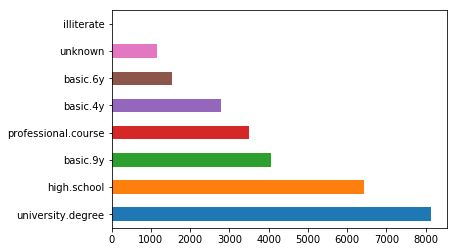

In [6]:
df["education"].value_counts().plot.barh();

La solution la plus simple consiste à mapper chaque valeur de cette fonction en un numéro unique. Par exemple, nous pouvons mapper `university.degree` à 0,` basic.9y` à 1, et ainsi de suite. Vous pouvez utiliser `sklearn.preprocessing.LabelEncoder` pour effectuer ce mappage.

In [7]:
label_encoder = LabelEncoder()

La méthode `fit` de cette classe trouve toutes les valeurs uniques et construit le mappage réel entre les catégories et les nombres, et la méthode` transform` convertit les catégories en nombres. Après l'exécution de `fit`,` label _encoder` aura l'attribut `classes_` avec toutes les valeurs uniques de l'entité. Comptons-les pour nous assurer que la transformation était correcte.

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


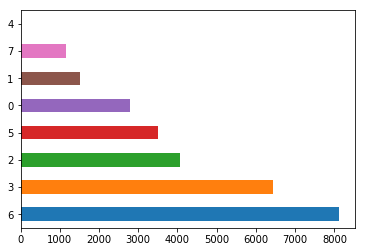

In [8]:
mapped_education = pd.Series(label_encoder.fit_transform(df["education"]))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [9]:
df["education"] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Appliquons la transformation à d'autres colonnes de type `objet`.

In [10]:
categorical_columns = df.columns[df.dtypes == "object"].union(["education"])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


Le principal problème avec cette approche est que nous avons maintenant introduit un ordre relatif là où il pourrait ne pas exister.

Par exemple, nous avons implicitement introduit l'algèbre sur les valeurs de la caractéristique **job** où nous pouvons maintenant soustraire le job du client #2 du job du client# 1:

In [11]:
df.loc[1].job - df.loc[2].job

-1.0

Cette opération a-t-elle un sens? Pas vraiment. Essayons de former la régression logisitique avec cette transformation de caractéristique.

In [12]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.as_matrix()
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels
    )

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))


print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6133
           1       0.00      0.00      0.00       766

   micro avg       0.89      0.89      0.89      6899
   macro avg       0.44      0.50      0.47      6899
weighted avg       0.79      0.89      0.84      6899



Nous pouvons voir que la régression logistique ne prédit jamais la classe 1. Afin d'utiliser des modèles linéaires avec des caractéristiques catégoriques, nous utiliserons une approche différente: One-Hot Encoding.

### 2.2. Encodage One-Hot

Supposons qu'une caractéristique puisse avoir l'une des 10 valeurs uniques. L'encodage One-Hot crée 10 nouvelles caractéristiques correspondant à ces valeurs uniques, toutes *sauf un* sont des zéros.

In [13]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


Cette idée est implémentée dans la classe `OneHotEncoder` de` sklearn.preprocessing`. Par défaut, OneHotEncoder transforme les données en une matrice creuse (sparse matrix) pour économiser de l'espace mémoire car la plupart des valeurs sont des zéros et parce que nous ne voulons pas utiliser plus de RAM. Cependant, dans cet exemple particulier, nous ne rencontrons pas de tels problèmes, nous allons donc utiliser une représentation matricielle "dense".

In [14]:
onehot_encoder = OneHotEncoder(sparse=False)

In [15]:
encoded_categorical_columns = pd.DataFrame(
    onehot_encoder.fit_transform(df[categorical_columns])
)
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Nous avons 53 colonnes qui correspondent au nombre de valeurs uniques des caractéristiques catégorielles dans notre ensemble de données. Lorsqu'elles sont transformées avec l'encodage One-Hot, ces données peuvent être utilisées avec des modèles linéaires:

In [16]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6140
           1       0.64      0.16      0.26       759

   micro avg       0.90      0.90      0.90      6899
   macro avg       0.77      0.57      0.60      6899
weighted avg       0.88      0.90      0.87      6899



### 2.3. Astuce de hachage
Les données réelles peuvent être volatiles, ce qui signifie que nous ne pouvons pas garantir que de nouvelles valeurs de caractéristiques catégorielles ne se produiront pas. Ce problème empêche l'utilisation d'un modèle entraîné sur de nouvelles données. En outre, «LabelEncoder» nécessite une analyse préliminaire de l'ensemble de données et le stockage des mappages construits en mémoire, ce qui rend difficile le travail avec de grands ensembles de données.

Il existe une approche simple de la vectorisation des données catégorielles basée sur le hachage et est connue sous le nom, sans surprise, de l'astuce de hachage.

Les fonctions de hachage peuvent nous aider à trouver des codes uniques pour différentes valeurs de caractéristiques, par exemple:

In [17]:
for s in ("university.degree", "high.school", "illiterate"):
    print(s, "->", hash(s))

university.degree -> -4819547379497397962
high.school -> 6407817176082389474
illiterate -> -426073671251698964


Nous n'utiliserons pas de valeurs négatives ou de valeurs de grande amplitude, nous limitons donc la plage de valeurs pour la fonction de hachage:

In [18]:
hash_space = 25
for s in ("university.degree", "high.school", "illiterate"):
    print(s, "->", hash(s) % hash_space)

university.degree -> 13
high.school -> 24
illiterate -> 11


Imaginons que notre ensemble de données contienne un étudiant célibataire (c'est-à-dire non marié), qui a reçu un appel lundi. Ses vecteurs de caractéristiques seront créés de la même manière que dans le cas de l'encodage One-Hot, mais dans l'espace avec une plage fixe pour toutes les caractéristiques:

In [19]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ("job=student", "marital=single", "day_of_week=mon"):
    print(s, "->", hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 9
marital=single -> 17
day_of_week=mon -> 15


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nous tenons à souligner que nous hachons non seulement les valeurs de caractéristique, mais également des paires de **nom de caractéristique + valeur de caractéristique**. Il est important de le faire afin que nous puissions distinguer les mêmes valeurs de différentes caractéristiques.

In [20]:
assert hash("no") == hash("no")
assert hash("housing=no") != hash("loan=no")

Est-il possible d'avoir une collision lors de l'utilisation de codes de hachage? Bien sûr, c'est possible, mais c'est un cas rare avec des espaces de hachage suffisamment grands. Même en cas de collision, les métriques de régression ou de classification n'en souffriront pas beaucoup. Dans ce cas, les collisions de hachage fonctionnent comme une forme de régularisation.


<img src="https://habrastorage.org/webt/4o/wx/59/4owx59vdvwc9mzrf81t2fa2rqrc.jpeg">

Vous dites peut-être "WTF?"; le hachage semble contre-intuitif. C'est vrai, mais ces heuristiques sont parfois, en fait, la seule approche plausible pour travailler avec des données catégorielles (que pouvez-vous faire d'autre si vous avez 30 millions de caractéristiques?). De plus, cette technique s'est avérée efficace. Au fur et à mesure que vous travaillez avec des données, vous pouvez le constater par vous-même.

Une bonne analyse des collisions de hachage, de leur dépendance à l'espace des caractéristiques et des dimensions de l'espace de hachage et affectant les performances de classification / régression est effectuée dans [cet article](https://booking.ai/dont-be-tricked-by-the-hashing- trick-192a6aae3087) par Booking.com.

## 3. Vowpal Wabbit

[Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit)(VW) est l'une des bibliothèques d'apprentissage automatique les plus répandues dans l'industrie. Il se distingue par sa vitesse d'entraînement et sa prise en charge de nombreux modes d'entraînement, en particulier pour l'apprentissage en ligne avec des données volumineuses et de haute dimension. C'est l'un des principaux mérites de la bibliothèque. De plus, avec l'astuce de hachage implémentée, Vowpal Wabbit est un choix parfait pour travailler avec des données textuelles.

Shell est l'interface principale de VW.

In [21]:
!vw --help

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1

VW options:
  --ring_size arg                       size of example ring
  --onethread                           Disable parse thread

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all weights t

Vowpal Wabbit lit les données des fichiers ou du flux d'entrée standard (stdin) avec le format suivant:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]`

`Features=(String[:Value] )*`

[] désigne des éléments non obligatoires et (...)* signifie plusieurs entrées autorisées.

- **Label** est un nombre. Dans le cas de la classification, il vaut généralement 1 et -1; pour la régression, c'est une vraie valeur flottante
- **Importance** est un nombre. Il indique le poids de l'échantillon pendant l'entraînement. Cette configuration aide lorsque vous travaillez avec des données déséquilibrées.
- **Tag** est une chaîne sans espaces. C'est le "nom" de l'échantillon que VW enregistre lors de la prédiction. Afin de séparer Tag de Importance, il est préférable de commencer Tag avec le caractère '.
- **Namespace** sert à créer différents espaces de caractéristiques.
- **Les caractéristiques** sont des caractéristiques d'objet à l'intérieur d'un **espace de noms** donné. Les caractéristiques ont un poids de 1,0 par défaut, mais il peut être modifié, par exemple caractéristique: 0,1.


La chaîne suivante correspond au format VW:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```


Vérifions le format en exécutant VW avec cet exemple d'entraînement:

In [22]:
! echo '1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park' | vw

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000       10

finished run
number of examples = 1
weighted example sum = 1.000000
weighted label sum = 1.000000
average loss = 1.000000
best constant = 1.000000
best constant's loss = 0.000000
total feature number = 10


VW est un outil formidable pour travailler avec des données textuelles. Nous allons l'illustrer avec le jeu de données [20newsgroups](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html), qui contient des articles de 20 newsletters différentes.


### 3.1. Articles. Classification binaire.

In [23]:
# load data with sklearn's function
newsgroups = fetch_20newsgroups(PATH_TO_ALL_DATA)

In [24]:
newsgroups["target_names"]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Regardons le premier document de cette collection:

In [25]:
text = newsgroups["data"][0]
target = newsgroups["target_names"][newsgroups["target"][0]]

print("-----")
print(target)
print("-----")
print(text.strip())
print("----")

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


Maintenant, nous convertissons les données en quelque chose que Vowpal Wabbit peut comprendre. Nous rejetterons les mots de moins de 3 symboles. Ici, nous allons sauter certaines étapes importantes du NLP telles que le stemming et la lemmatisation; cependant, nous verrons plus tard que VW résout le problème même sans ces étapes.

In [26]:
def to_vw_format(document, label=None):
    return (
        str(label or "")
        + " |text "
        + " ".join(re.findall("\w{3,}", document.lower()))
        + "\n"
    )


to_vw_format(text, 1 if target == "rec.autos" else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

Nous divisons l'ensemble de données en **train** et **test** et les écrivons dans des fichiers séparés. Nous considérerons un document comme positif s'il correspond à **rec.autos**. Ainsi, nous construisons un modèle qui distingue les articles sur les voitures d'autres sujets:

In [27]:
all_documents = newsgroups["data"]
all_targets = [
    1 if newsgroups["target_names"][target] == "rec.autos" else -1
    for target in newsgroups["target"]
]

In [28]:
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_documents, all_targets, random_state=7
)

with open(os.path.join(PATH_TO_ALL_DATA, "20news_train.vw"), "w") as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join(PATH_TO_ALL_DATA, "20news_test.vw"), "w") as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Maintenant, nous transmettons le fichier de formation créé à Vowpal Wabbit. Nous résolvons le problème de classification avec une fonction de perte charnière (SVM linéaire). Le modèle entraîné sera enregistré dans le fichier `20news_model.vw`:

In [29]:
!vw -d $PATH_TO_ALL_DATA/20news_train.vw \
 --loss_function hinge -f $PATH_TO_ALL_DATA/20news_model.vw

final_regressor = ../../data//20news_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data//20news_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      157
0.911276 0.822551            2            2.0  -1.0000  -0.1774      159
0.605793 0.300311            4            4.0  -1.0000  -0.3994       92
0.419594 0.233394            8            8.0  -1.0000  -0.8167      129
0.313998 0.208402           16           16.0  -1.0000  -0.6509      108
0.196014 0.078029           32           32.0  -1.0000  -1.0000      115
0.183158 0.170302           64           64.0  -1.0000  -0.7072      114
0.261046 0.338935          128          128.0   1.0000  -0.7900      110
0.262910 0.264774          256          256.0  -1.0000  -0.6425       44
0.21

VW imprime beaucoup d'informations intéressantes pendant l'entraînement (on peut les supprimer avec le paramètre `--quiet`). Vous pouvez voir la documentation de la sortie de diagnostic sur [GitHub](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial#vws-diagnostic-information). Notez comment la perte moyenne diminue pendant l'entraînement. Pour le calcul des pertes, VW utilise des échantillons qu'il n'a jamais vus auparavant, donc cette mesure est généralement précise. Maintenant, nous appliquons notre modèle entraîné à l'ensemble de test, en enregistrant les prédictions dans un fichier avec l'indicateur `-p`:

In [30]:
!vw -i $PATH_TO_ALL_DATA/20news_model.vw -t -d $PATH_TO_ALL_DATA/20news_test.vw \
-p $PATH_TO_ALL_DATA/20news_test_predictions.txt

only testing
predictions = ../../data//20news_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data//20news_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   1.0000      349
    n.a.     n.a.            2            2.0  unknown  -1.0000       50
    n.a.     n.a.            4            4.0  unknown  -1.0000      251
    n.a.     n.a.            8            8.0  unknown  -1.0000      237
    n.a.     n.a.           16           16.0  unknown  -0.8978      106
    n.a.     n.a.           32           32.0  unknown  -1.0000      964
    n.a.     n.a.           64           64.0  unknown  -1.0000      261
    n.a.     n.a.          128          128.0  unknown   0.4621       82
    n.a.     n.a.          256          256.0  unknown  -

Maintenant, nous chargeons nos prédictions, calculons AUC et traçons la courbe ROC:

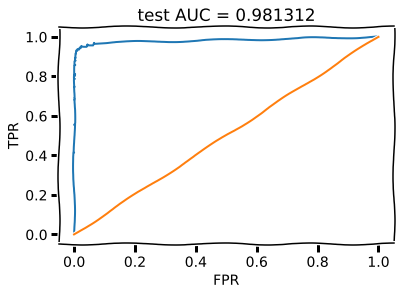

In [31]:
with open(os.path.join(PATH_TO_ALL_DATA, "20news_test_predictions.txt")) as pred_file:
    test_prediction = [float(label) for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1])
    plt.plot([0, 1], [0, 1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("test AUC = %f" % (auc))
    plt.axis([-0.05, 1.05, -0.05, 1.05]);

La valeur AUC que nous obtenons montre que nous avons atteint une qualité de classification élevée.

### 3.2. Articles. Classification multiclasse

Nous utiliserons le même jeu de données d'actualités, mais, cette fois, nous allons résoudre un problème de classification multiclasse. «Vowpal Wabbit» est un peu pointilleux - il veut des étiquettes commençant de 1 à K, où K - est le nombre de classes dans la tâche de classification (20 dans notre cas). Nous allons donc utiliser LabelEncoder et ajouter 1 par la suite (rappelez-vous que `LabelEncoder` mappe les étiquettes dans la plage de 0 à K-1).

In [32]:
all_documents = newsgroups["data"]
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups["target"]) + 1

**Les données sont les mêmes, mais nous avons changé les étiquettes, train_labels_mult et test_labels_mult, en vecteurs d'étiquettes de 1 à 20.**

In [33]:
train_documents, test_documents, train_labels_mult, test_labels_mult = train_test_split(
    all_documents, all_targets_mult, random_state=7
)

with open(os.path.join(PATH_TO_ALL_DATA, "20news_train_mult.vw"), "w") as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join(PATH_TO_ALL_DATA, "20news_test_mult.vw"), "w") as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Nous entraînons Vowpal Wabbit en mode de classification multiclasse, en passant le paramètre `oaa` (" un contre tous ") avec le nombre de classes. Voyons également de quels paramètres la qualité de notre modèle dépend (plus d'informations peuvent être trouvées dans le [tutoriel officiel de Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial)):
 - learning rate (-l, 0,5 par défaut) - taux de changement de poids à chaque pas
 - learning rate decay (--power_ t, 0.5 par défaut) - il est prouvé en pratique que, si le taux d'apprentissage diminue avec le nombre de pas en descente de gradient stochastique, on approche mieux la perte minimale
 - loss function (fonction --loss _) - tout l'algorithme d'apprentissage en dépend. Voir [docs](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions) pour les fonctions de perte
 - Regularization (-l1) - notez que VW calcule la régularisation pour chaque objet. C'est pourquoi nous définissons généralement les valeurs de régularisation à environ $10^{-20}.$
 
De plus, nous pouvons essayer le réglage automatique des paramètres Vowpal Wabbit avec [Hyperopt](https://github.com/hyperopt/hyperopt).

In [34]:
%%time
!vw --oaa 20 $PATH_TO_ALL_DATA/20news_train_mult.vw -f $PATH_TO_ALL_DATA/20news_model_mult.vw \
--loss_function=hinge

final_regressor = ../../data//20news_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data//20news_train_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       15        1      157
1.000000 1.000000            2            2.0        2       15      159
1.000000 1.000000            4            4.0       15       10       92
1.000000 1.000000            8            8.0       16       15      129
1.000000 1.000000           16           16.0       13       12      108
0.937500 0.875000           32           32.0        2        9      115
0.906250 0.875000           64           64.0       16       16      114
0.867188 0.828125          128          128.0        8        4      110
0.816406 0.765625          256          256.0        7       15    

In [35]:
%%time
!vw -i $PATH_TO_ALL_DATA/20news_model_mult.vw -t -d $PATH_TO_ALL_DATA/20news_test_mult.vw \
-p $PATH_TO_ALL_DATA/20news_test_predictions_mult.txt

only testing
predictions = ../../data//20news_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data//20news_test_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown        8      349
    n.a.     n.a.            2            2.0  unknown        6       50
    n.a.     n.a.            4            4.0  unknown       18      251
    n.a.     n.a.            8            8.0  unknown       18      237
    n.a.     n.a.           16           16.0  unknown        4      106
    n.a.     n.a.           32           32.0  unknown       15      964
    n.a.     n.a.           64           64.0  unknown        4      261
    n.a.     n.a.          128          128.0  unknown        8       82
    n.a.     n.a.          256          256.0  

In [36]:
with open(
    os.path.join(PATH_TO_ALL_DATA, "20news_test_predictions_mult.txt")
) as pred_file:
    test_prediction_mult = [float(label) for label in pred_file.readlines()]

In [37]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.8734535171438671

Voici à quelle fréquence le modèle classe mal l'athéisme avec d'autres sujets:

In [38]:
M = confusion_matrix(test_labels_mult, test_prediction_mult)
for i in np.where(M[0, :] > 0)[0][1:]:
    print(newsgroups["target_names"][i], M[0, i])

rec.autos 1
rec.sport.baseball 1
sci.med 1
soc.religion.christian 3
talk.religion.misc 5


### 3.3. Critiques de films IMDB
Dans cette partie, nous ferons la classification binaire des critiques de films [IMDB](http://www.imdb.com) (International Movie DataBase). Nous verrons à quelle vitesse Vowpal Wabbit fonctionne.

En utilisant la fonction `load_files` de` sklearn.datasets`, nous chargeons les ensembles de données des critiques de films. C'est le même jeu de données que nous avons utilisé dans le notebook topic04 part4.

In [39]:
import tarfile

# Download the dataset if not already in place
from io import BytesIO

import requests

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


def load_imdb_dataset(extract_path="../../data", overwrite=False):
    # check if existed already
    if (
        os.path.isfile(os.path.join(extract_path, "aclImdb", "README"))
        and not overwrite
    ):
        print("IMDB dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    tar = tarfile.open(mode="r:gz", fileobj=BytesIO(response.content))

    data = tar.extractall(extract_path)


load_imdb_dataset()

IMDB dataset is already in place.


Lire les données du train, séparer les étiquettes.

In [40]:
PATH_TO_IMDB = "../../data/aclImdb"

reviews_train = load_files(
    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
)

text_train, y_train = reviews_train.data, reviews_train.target

In [41]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


Faire de même pour l'ensemble de test.

In [42]:
reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=["pos", "neg"])
text_test, y_test = reviews_test.data, reviews_test.target

In [43]:
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


Jetez un œil à des exemples d'avis et leurs libellés correspondants.

In [44]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [45]:
y_train[0]  # good review

1

In [46]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [47]:
y_train[1]  # bad review

0

In [48]:
to_vw_format(str(text_train[1]), 1 if y_train[0] == 1 else -1)

'1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

Maintenant, nous préparons l'apprentissage (`movie _reviews_ train.vw`), la validation (` movie _reviews_ valid.vw`) et le test (`movie _reviews_ test.vw`) définit pour Vowpal Wabbit. Nous utiliserons 70% pour la formation, 30% pour le reste.

In [49]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [50]:
len(train_labels), len(valid_labels)

(17500, 7500)

In [51]:
with open(
    os.path.join(PATH_TO_ALL_DATA, "movie_reviews_train.vw"), "w"
) as vw_train_data:
    for text, target in zip(train, train_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open(
    os.path.join(PATH_TO_ALL_DATA, "movie_reviews_valid.vw"), "w"
) as vw_train_data:
    for text, target in zip(valid, valid_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open(os.path.join(PATH_TO_ALL_DATA, "movie_reviews_test.vw"), "w") as vw_test_data:
    for text in text_test:
        vw_test_data.write(to_vw_format(str(text)))

In [52]:
!head -2 $PATH_TO_ALL_DATA/movie_reviews_train.vw

1 |text zero day leads you think even think why two boys young men would what they did commit mutual suicide via slaughtering their classmates captures what must beyond bizarre mode being for two humans who have decided withdraw from common civility order define their own mutual world via coupled destruction not perfect movie but given what money time the filmmaker and actors had remarkable product terms explaining the motives and actions the two young suicide murderers better than elephant terms being film that gets under our rationalistic skin far far better film than almost anything you are likely see flawed but honest with terrible honesty
-1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regardi

In [53]:
!head -2 $PATH_TO_ALL_DATA/movie_reviews_valid.vw

1 |text matter life and death what can you really say that would properly justice the genius and beauty this film powell and pressburger visual imagination knows bounds every frame filled with fantastically bold compositions the switches between the bold colours the real world the stark black and white heaven ingenious showing visually just how much more vibrant life the final court scene also fantastic the judge and jury descend the stairway heaven hold court over peter david niven operation all the performances are spot roger livesey being standout and the romantic energy the film beautiful never has there been more romantic film than this there has haven seen matter life and death all about the power love and just how important life and jack cardiff cinematography reason enough watch the film alone the way lights kim hunter face makes her all the more beautiful what genius can make simple things such game table tennis look exciting and the sound design also impeccable the way the so

In [54]:
!head -2 $PATH_TO_ALL_DATA/movie_reviews_test.vw

 |text don hate heather graham because she beautiful hate her because she fun watch this movie like the hip clothing and funky surroundings the actors this flick work well together casey affleck hysterical and heather graham literally lights the screen the minor characters goran visnjic sigh and patricia velazquez are talented they are gorgeous congratulations miramax director lisa krueger
 |text don know how this movie has received many positive comments one can call artistic and beautifully filmed but those things don make for the empty plot that was filled with sexual innuendos wish had not wasted time watch this movie rather than being biographical was poor excuse for promoting strange and lewd behavior was just another hollywood attempt convince that that kind life normal and from the very beginning asked self what was the point this movie and continued watching hoping that would change and was quite disappointed that continued the same vein glad did not spend the money see this t

**Nous lançons maintenant Vowpal Wabbit avec les arguments suivants:**

 - `-d`, chemin vers l'ensemble d'entraînement (fichier .vw correspondant)
 - `--loss_function` - charnière (n'hésitez pas à expérimenter ici)
 - `-f` - chemin vers le fichier de sortie (qui peut également être au format .vw)

In [55]:
!vw -d $PATH_TO_ALL_DATA/movie_reviews_train.vw --loss_function hinge \
-f $PATH_TO_ALL_DATA/movie_reviews_model.vw --quiet

Ensuite, faites la prédiction de hold-out avec les arguments VW suivants:
 - `-i` - chemin vers le modèle entraîné (fichier .vw)
 - `-d` - chemin vers le jeu d'exclusion (fichier .vw)
 - `-p` - chemin vers un fichier txt où les prédictions seront stockées
 - `-t` - dit à VW d'ignorer les étiquettes

In [56]:
!vw -i $PATH_TO_ALL_DATA/movie_reviews_model.vw -t \
-d $PATH_TO_ALL_DATA/movie_reviews_valid.vw -p $PATH_TO_ALL_DATA/movie_valid_pred.txt --quiet

Lisez les prédictions du fichier texte et estimez la précision et l'AUC ROC. Notez que VW imprime les estimations de probabilité de la classe +1. Ces estimations sont distribuées de -1 à 1, nous pouvons donc les convertir en réponses binaires, en supposant que les valeurs positives appartiennent à la classe 1.

In [57]:
with open(os.path.join(PATH_TO_ALL_DATA, "movie_valid_pred.txt")) as pred_file:
    valid_prediction = [float(label) for label in pred_file.readlines()]
print(
    "Accuracy: {}".format(
        round(
            accuracy_score(
                valid_labels, [int(pred_prob > 0) for pred_prob in valid_prediction]
            ),
            3,
        )
    )
)
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.885
AUC: 0.942


Encore une fois, faites de même pour l'ensemble de test.

In [58]:
!vw -i $PATH_TO_ALL_DATA/movie_reviews_model.vw -t \
-d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
-p $PATH_TO_ALL_DATA/movie_test_pred.txt --quiet

In [59]:
with open(os.path.join(PATH_TO_ALL_DATA, "movie_test_pred.txt")) as pred_file:
    test_prediction = [float(label) for label in pred_file.readlines()]
print(
    "Accuracy: {}".format(
        round(
            accuracy_score(
                y_test, [int(pred_prob > 0) for pred_prob in test_prediction]
            ),
            3,
        )
    )
)
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Accuracy: 0.88
AUC: 0.94


Essayons d'obtenir une plus grande précision en incorporant des bigrammes.

In [60]:
!vw -d $PATH_TO_ALL_DATA/movie_reviews_train.vw \
--loss_function hinge --ngram 2 -f $PATH_TO_ALL_DATA/movie_reviews_model2.vw --quiet

In [61]:
!vw -i$PATH_TO_ALL_DATA/movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_valid.vw \
-p $PATH_TO_ALL_DATA/movie_valid_pred2.txt --quiet

In [62]:
with open(os.path.join(PATH_TO_ALL_DATA, "movie_valid_pred2.txt")) as pred_file:
    valid_prediction = [float(label) for label in pred_file.readlines()]
print(
    "Accuracy: {}".format(
        round(
            accuracy_score(
                valid_labels, [int(pred_prob > 0) for pred_prob in valid_prediction]
            ),
            3,
        )
    )
)
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.894
AUC: 0.954


In [63]:
!vw -i $PATH_TO_ALL_DATA/movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
-p $PATH_TO_ALL_DATA/movie_test_pred2.txt --quiet

In [64]:
with open(os.path.join(PATH_TO_ALL_DATA, "movie_test_pred2.txt")) as pred_file:
    test_prediction2 = [float(label) for label in pred_file.readlines()]
print(
    "Accuracy: {}".format(
        round(
            accuracy_score(
                y_test, [int(pred_prob > 0) for pred_prob in test_prediction2]
            ),
            3,
        )
    )
)
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))

Accuracy: 0.888
AUC: 0.952


L'ajout de bigrammes a vraiment aidé à améliorer notre modèle!

### 3.4. Classer des gigaoctets de questions StackOverflow

Cette section a été déplacée vers Kaggle, veuillez explorer [ce noyau](https://www.kaggle.com/kashnitsky/topic-8-online-learning-and-vowpal-wabbit).

## 4. Mission de démonstration
Pour mieux comprendre l'apprentissage stochastique, vous pouvez effectuer [cette tâche](https://www.kaggle.com/kashnitsky/assignment-8-implementing-online-regressor) où il vous sera demandé d'implémenter un régresseur de gradient stochastique à partir de zéro . La mission est juste pour que vous vous entraîniez, et va avec une [solution](https://www.kaggle.com/kashnitsky/a8-demo-implementing-online-regressor-solution).

## 5. Ressources utiles
- The same notebook as am interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-8-online-learning-and-vowpal-wabbit)
- ["Training while reading"](https://www.kaggle.com/kashnitsky/training-while-reading-vowpal-wabbit-starter) - an example of the Python wrapper usage
- Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- Official VW [documentation](https://github.com/JohnLangford/vowpal_wabbit/wiki) on Github
- ["Awesome Vowpal Wabbit"](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Awesome-Vowpal-Wabbit) Wiki
- [Don’t be tricked by the Hashing Trick](https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087) - analysis of hash collisions, their dependency on feature space and hashing space dimensions and affecting classification/regression performance
- ["Numeric Computation" Chapter](http://www.deeplearningbook.org/contents/numerical.html) of the [Deep Learning book](http://www.deeplearningbook.org/)
- ["Convex Optimization" by Stephen Boyd](https://www.amazon.com/Convex-Optimization-Stephen-Boyd/dp/0521833787)
- "Command-line Tools can be 235x Faster than your Hadoop Cluster" [post](https://aadrake.com/command-line-tools-can-be-235x-faster-than-your-hadoop-cluster.html)
- Benchmarking various ML algorithms on Criteo 1TB dataset on [GitHub](https://github.com/rambler-digital-solutions/criteo-1tb-benchmark)
- [VW on FastML.com](http://fastml.com/blog/categories/vw/)